<a href="https://colab.research.google.com/github/tedyadika/Azureml/blob/main/2_Data_eng_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Azure ML SDK modules

In [4]:
!pip install azureml.core
!pip install numpy == 1.20
!pip install pycaret
!pip install azureml-dataset-runtime --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Invalid requirement: '=='
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from azureml.core import Workspace, Datastore,Dataset,Experiment,Run

### Import python modules

In [6]:
%matplotlib inline
import datetime
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date,timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib
from pycaret.regression import *
#from lazypredict.Supervised import LazyRegressor

### Set up and data import 

In [7]:
ws = Workspace.get(name= 'dscglobalceedamlt',
                    subscription_id= '8b20e38c-72fb-4030-a702-128e713479ca',
                    resource_group= 'DSCGlobalCEEDTANLTst')

az_store= Datastore.get(ws,'datastore_sdk_blob1')
az_dataset= Dataset.get_by_name(ws,'country_sdk')
az_default_store = ws.get_default_datastore()

Performing interactive authentication. Please follow the instructions on the terminal.


Interactive authentication successfully completed.


### set up experiment

In [8]:
experiment_run = Run.get_context()

In [9]:
dataset1 =az_dataset.to_pandas_dataframe()


Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


In [10]:
df = dataset1.copy()
df = df.drop(['DCRPL','ECOMM','RETAIL'], axis=1)
df['logarithm_base2'] = np.log10(df['SUM_QTY_TOTAL_PICKS'])

In [11]:
nulldf = df.isnull().sum()
for col in df.columns:
    experiment_run.log(col, nulldf[col])

Attempted to log scalar metric DATE:
0
Attempted to log scalar metric ORDTYP_map:
0
Attempted to log scalar metric DAY_YEAR:
0
Attempted to log scalar metric day_of_week:
0
Attempted to log scalar metric COUNTRY_NAME:
0
Attempted to log scalar metric NBR_ORDERS:
0
Attempted to log scalar metric SUM_QTY_TOTAL_PICKS:
0
Attempted to log scalar metric SUM_QTY_PIECE_PICKS:
0
Attempted to log scalar metric Month:
0
Attempted to log scalar metric Year:
0
Attempted to log scalar metric WEEK_YEAR:
0
Attempted to log scalar metric DATE_N:
0
Attempted to log scalar metric logarithm_base2:
0


### ploting

<Figure size 720x216 with 0 Axes>

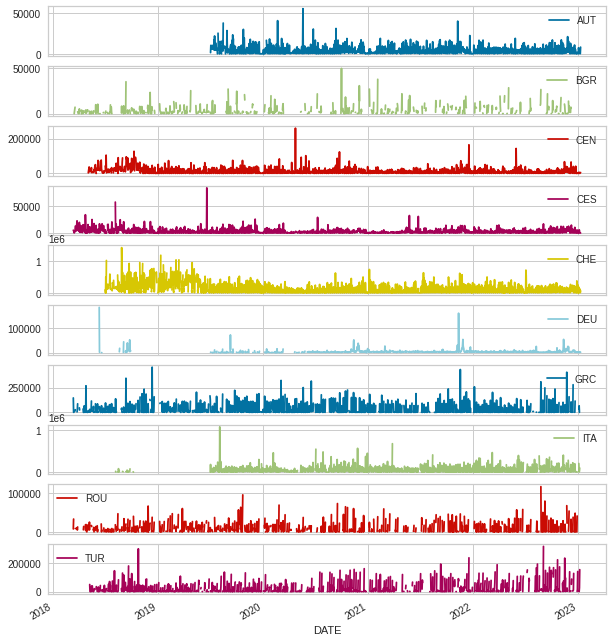

In [12]:
plt.figure(figsize=(10,3))   
pd.pivot_table(df.reset_index(),
               index='DATE', columns='COUNTRY_NAME', values='SUM_QTY_TOTAL_PICKS'
              ).plot(subplots=True,figsize=(10, 12))
           
plt.show()

### spliting our data by country 

In [13]:
# Initialize an empty list
df_list = []
# Split the dataframe into separate datasets based on the values in the 'country' column
for name, group in df.groupby('COUNTRY_NAME'):
  df_list.append(group)

# Print the list of dataframes
#print(df_list)


### Adding importang parameters to our data

In [14]:
def add_values(data):
    #data = df.copy()
    #data['logarithm_base2'] = np.log10(data['SUM_QTY_TOTAL_PICKS'])
    data.sort_values('DATE', inplace=True)
    data['DATE'] = pd.to_datetime(data['DATE'])
    data['MA18'] = data['logarithm_base2'].shift(35).rolling(2).mean()
    data['MA16'] = data['logarithm_base2'].shift(21).rolling(7).mean()
    data['Month'] = [i.month for i in data['DATE']]
    data['Year'] = [i.year for i in data['DATE']]
    data['WEEK_YEAR'] = data['DATE'].dt.isocalendar().week 
    data['day_of_week'] = data['DATE'].dt.dayofweek
    data['DAY_YEAR'] = data['DATE'].dt.dayofyear
    data['DATE_N'] = data['DATE'].apply(lambda x:x.toordinal())
    data["WEEK_YEAR"] = data["WEEK_YEAR"].astype('int64').astype('int64')
    #data = data.dropna()
    return(data)


for df in df_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)




### Adding Lags

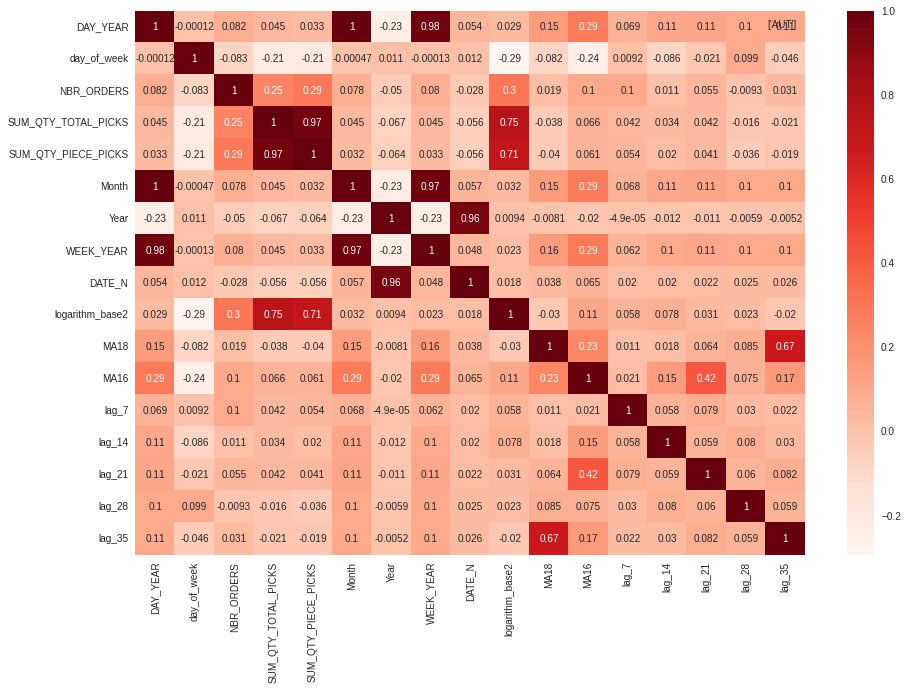

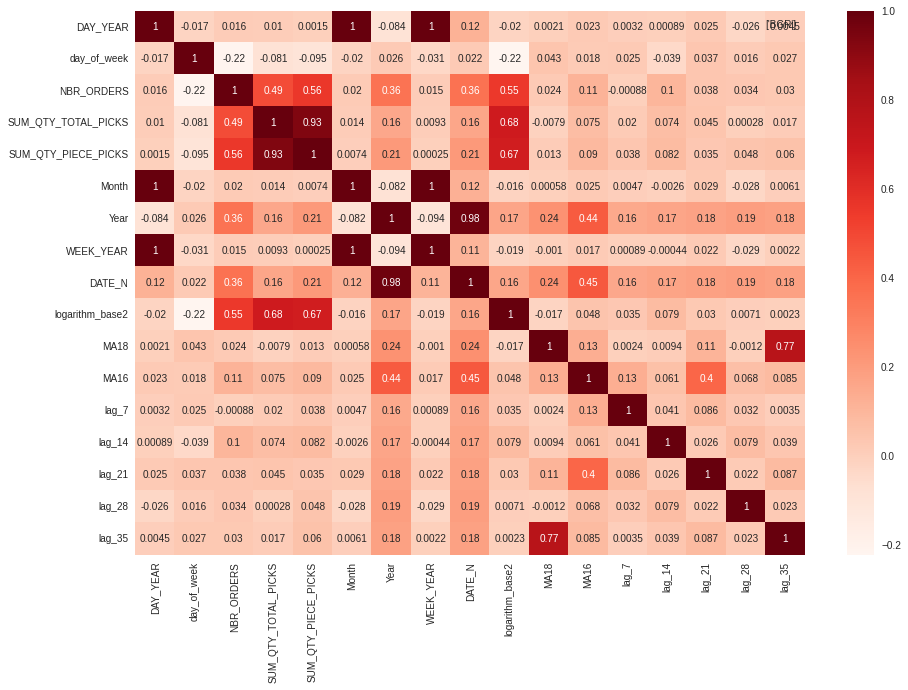

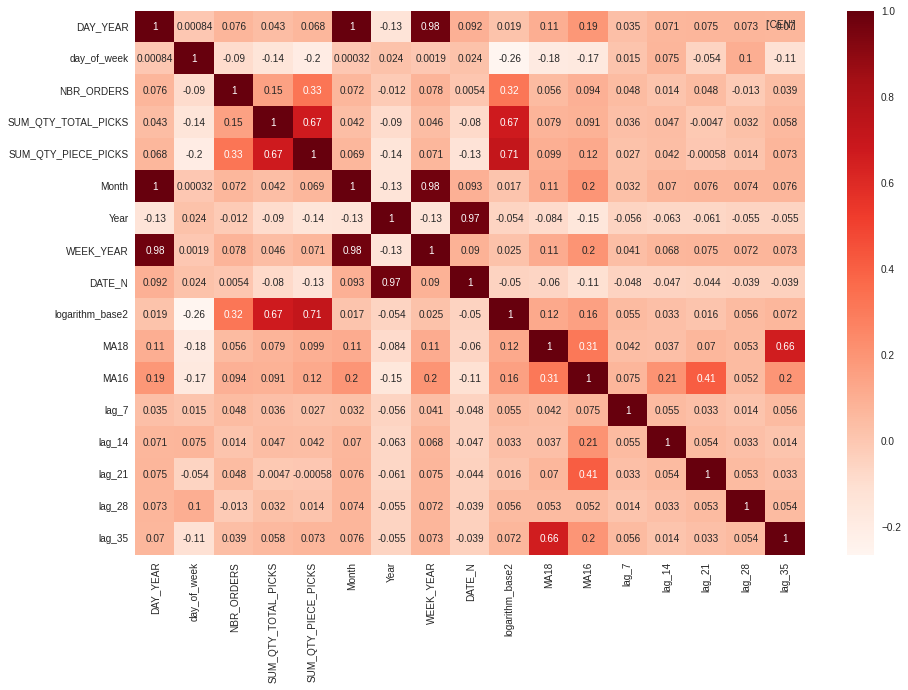

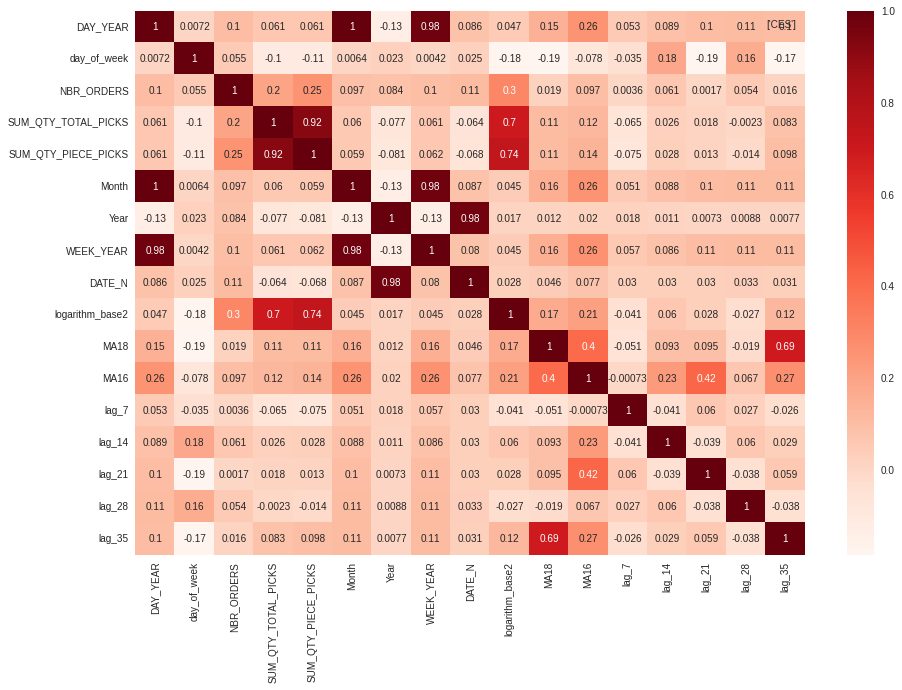

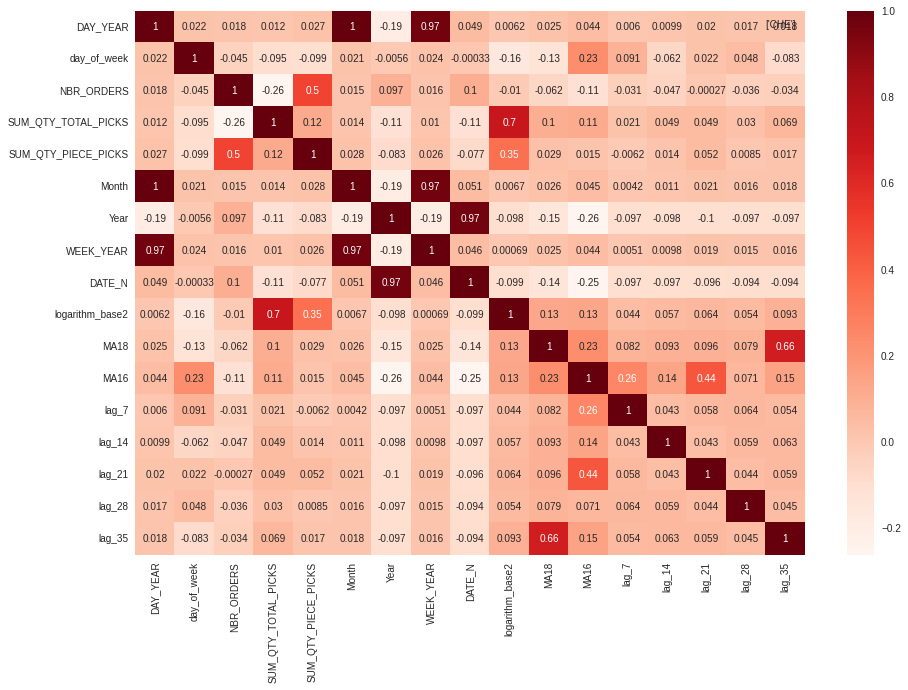

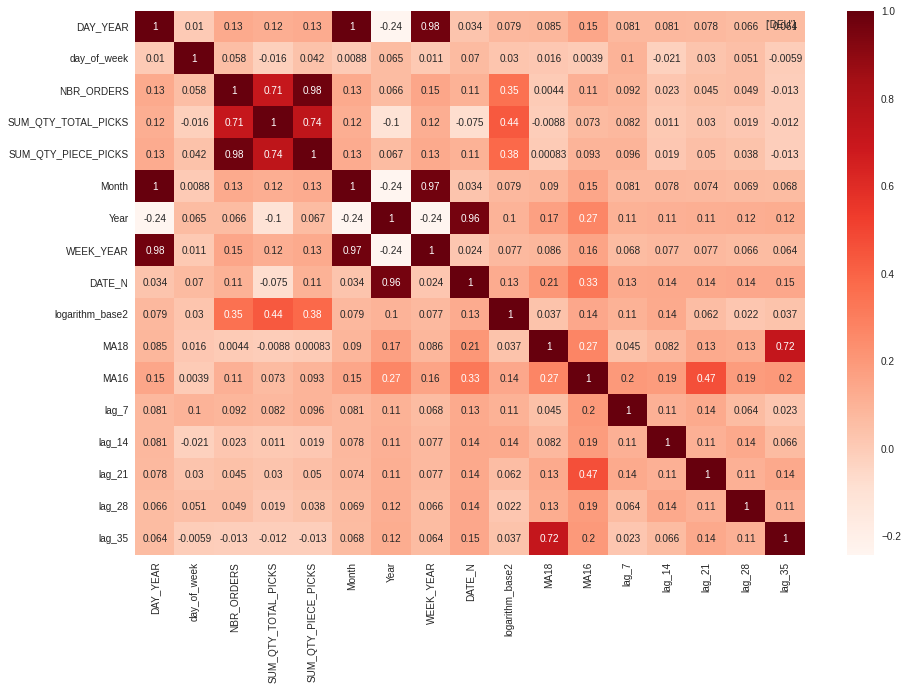

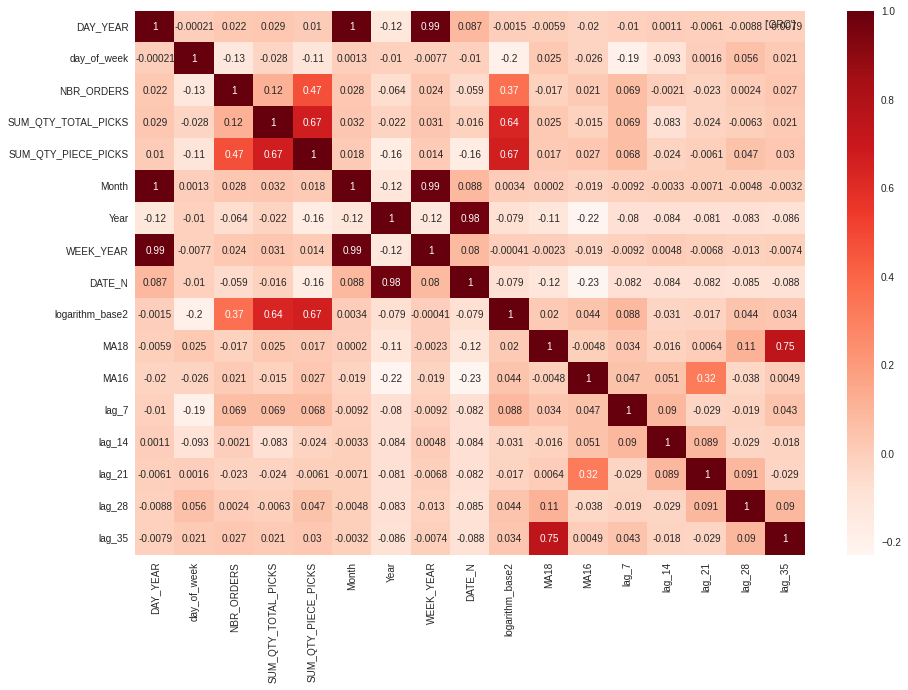

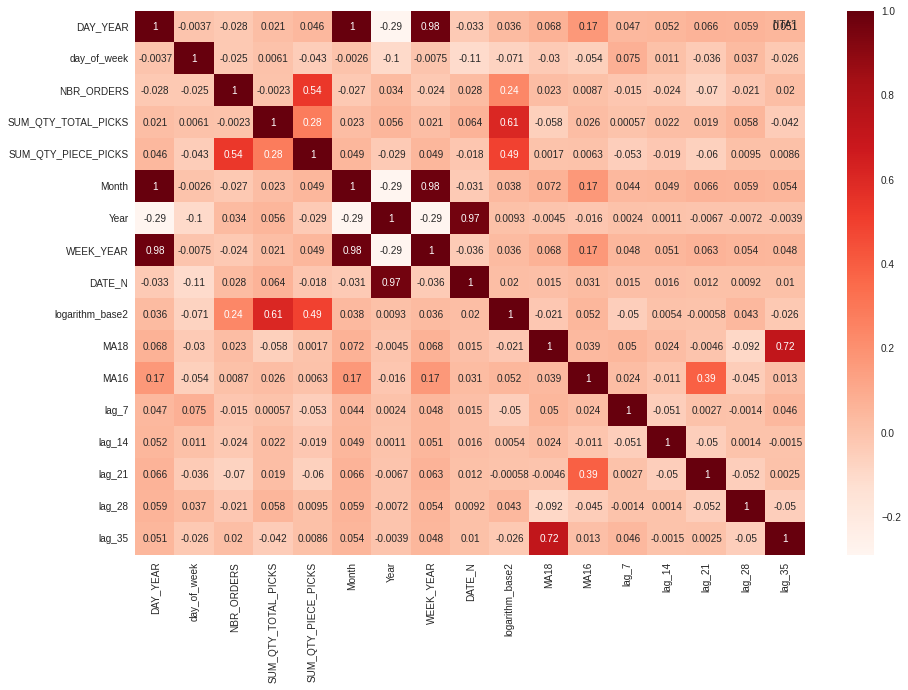

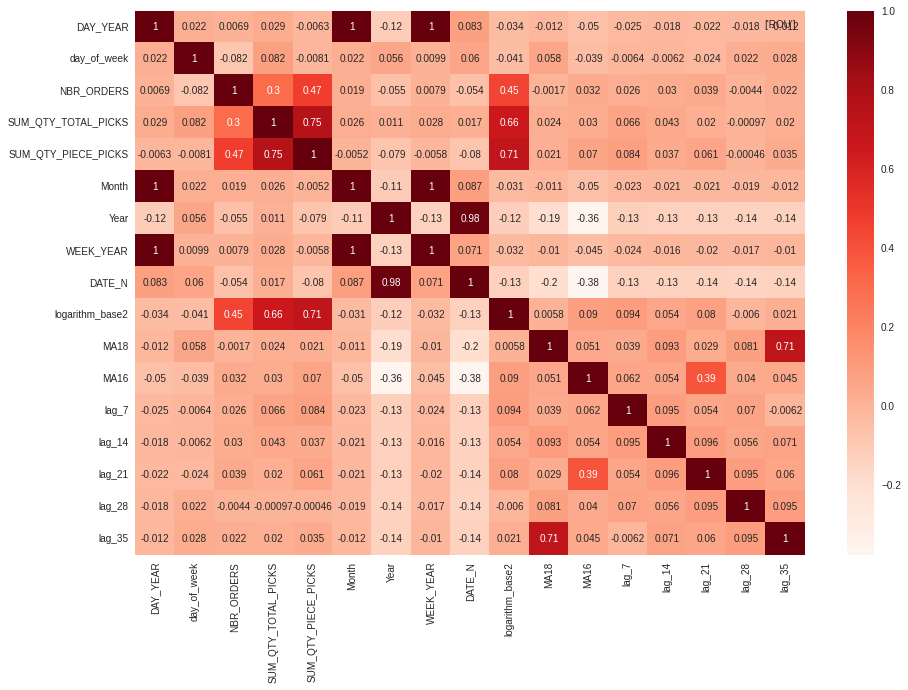

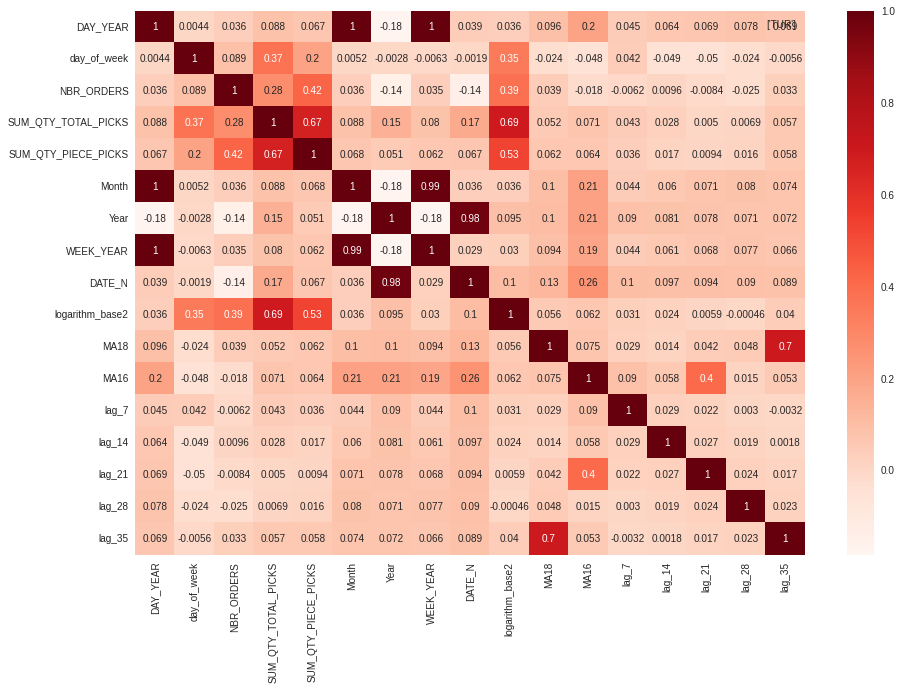

In [15]:
for df in df_list:
    label= df['COUNTRY_NAME'].unique()
    plt.figure(figsize=(15,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.legend(title = label)
    plt.show()

### AUSTRIA ML

In [16]:
Aut_data = df_list[0].copy()
Aut_data = Aut_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)

### setting up our Algorithm

In [17]:
s = setup(Aut_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

### comparing and finding best model

In [18]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.5738,4.457000e-01,0.6675,1.313000e-01,0.1658,0.1922,0.1500
rf,Random Forest Regressor,0.5738,4.482000e-01,0.6693,1.267000e-01,0.1672,0.1951,1.0567
omp,Orthogonal Matching Pursuit,0.5765,4.494000e-01,0.6703,1.234000e-01,0.1671,0.1938,0.0233
gbr,Gradient Boosting Regressor,0.5810,4.781000e-01,0.6913,6.700000e-02,0.1712,0.1931,0.3467
et,Extra Trees Regressor,0.5871,4.826000e-01,0.6934,5.700000e-02,0.1736,0.2005,0.5867
lightgbm,Light Gradient Boosting Machine,0.5882,4.991000e-01,0.7058,2.670000e-02,0.1759,0.1995,0.3367
huber,Huber Regressor,0.6177,5.214000e-01,0.7219,-1.560000e-02,0.1806,0.2106,0.0233
dummy,Dummy Regressor,0.6164,5.232000e-01,0.7232,-1.930000e-02,0.1805,0.2091,0.0167
llar,Lasso Least Angle Regression,0.6164,5.232000e-01,0.7232,-1.930000e-02,0.1805,0.2091,0.0167
ridge,Ridge Regression,0.6127,5.302000e-01,0.7257,-3.800000e-02,0.1830,0.2103,0.0167


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123)
INFO:logs:compare_models() succesfully completed......................................


In [19]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

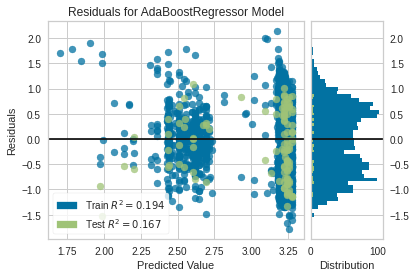

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [20]:
plot_model(best, plot = 'residuals')

### ploting our best features 

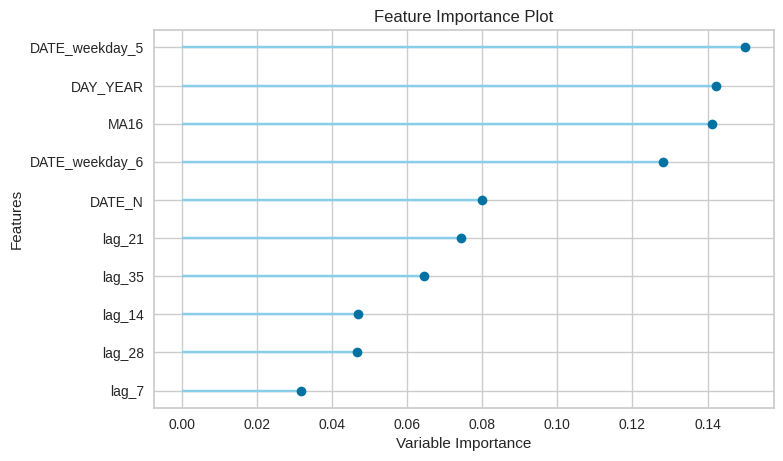

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [21]:
plot_model(best, plot = 'feature')

In [22]:
predict_model(best)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.559,0.4173,0.646,0.167,0.1573,0.1827


,DAY_YEAR,WEEK_YEAR,DATE_N,MA18,MA16,lag_7,lag_14,lag_21,lag_28,lag_35,...,DATE_month_6,DATE_month_8,DATE_weekday_1,DATE_weekday_2,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_0,DATE_is_month_start_0,logarithm_base2,Label
0,311.0,45.0,738466.0,2.817362,3.124837,4.528865,2.462398,2.478566,2.305351,2.472756,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.631444,3.259218
1,311.0,45.0,738466.0,3.033243,3.385449,2.440909,2.568202,4.276071,2.451787,3.593729,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.433450,3.276523
2,312.0,45.0,738467.0,3.744493,3.394787,3.786893,3.972989,2.562293,2.496930,3.895257,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.340246,3.240649
3,312.0,45.0,738467.0,3.144854,3.303147,2.428135,3.730944,3.682867,4.324344,2.394452,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.502427,3.240649
4,313.0,45.0,738468.0,3.321004,3.083326,1.000000,2.517196,2.399674,3.938420,4.247556,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.859138,3.224903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,7.0,1.0,738527.0,3.210577,2.908071,3.868586,2.977724,2.158362,3.444045,3.672190,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.724276,2.541921
110,7.0,1.0,738527.0,3.092037,2.876898,3.788027,2.906335,2.158362,2.376577,2.511883,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.627366,2.506759
111,8.0,1.0,738528.0,2.184608,2.818676,2.731589,2.673942,3.407561,3.815113,1.857332,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.578639,2.603568
112,9.0,2.0,738529.0,2.137817,2.624435,3.399154,1.505150,2.665581,4.025265,2.418301,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.205367,3.224903


### **Save the model** 

In [23]:
save_model(best, 'AUT_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), model_name=AUT_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['COUNTRY_NAME'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='logarithm_base2',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerica...
                ('scaling', 'passthrough'), ('P_transform',

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['COUNTRY_NAME'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='logarithm_base2',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerica...
                 ('dummy', Dummify(target='logarithm_base2')),
                 ('fix_perfect', Remove_100(target='logarithm_base2')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'

## loading saved model

In [24]:
loaded_model = load_model('AUT_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=AUT_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


## creating future dataset

In [25]:
prediction_df =[]

In [26]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([Aut_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [27]:
Aut_future = future_list[0].tail(10)
Aut_future = Aut_future.drop('logarithm_base2',axis = 1)
predictions_aut = predict_model(best, data=Aut_future)
predictions_aut['prediction'] = 10 ** predictions_aut['Label'] 
predictions_aut['COUNTRY_NAME'] ='AUT' 
prediction_df.append(predictions_aut)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


### **BGR ML**

In [28]:
BGR_data = df_list[1].copy()
BGR_data = BGR_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)

### Setting up Algorithm 

In [29]:
s = setup(BGR_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

### comparing models

In [30]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,6.802000e-01,6.965000e-01,8.342000e-01,-8.700000e-03,0.2325,2.792000e-01,0.0167
huber,Huber Regressor,7.211000e-01,7.435000e-01,8.622000e-01,-7.070000e-02,0.2424,3.096000e-01,0.0200
lasso,Lasso Regression,6.939000e-01,7.504000e-01,8.657000e-01,-7.500000e-02,0.2474,3.203000e-01,0.0400
en,Elastic Net,6.939000e-01,7.533000e-01,8.673000e-01,-7.860000e-02,0.2480,3.214000e-01,0.0333
br,Bayesian Ridge,6.831000e-01,7.528000e-01,8.673000e-01,-8.130000e-02,0.2468,3.136000e-01,0.0200
dummy,Dummy Regressor,7.377000e-01,7.604000e-01,8.720000e-01,-9.700000e-02,0.2434,3.102000e-01,0.0167
llar,Lasso Least Angle Regression,7.377000e-01,7.604000e-01,8.720000e-01,-9.700000e-02,0.2434,3.102000e-01,0.0267
knn,K Neighbors Regressor,7.136000e-01,7.648000e-01,8.745000e-01,-1.049000e-01,0.2476,3.168000e-01,0.0267
ada,AdaBoost Regressor,7.205000e-01,7.633000e-01,8.728000e-01,-1.083000e-01,0.2430,2.986000e-01,0.1033
rf,Random Forest Regressor,7.146000e-01,7.820000e-01,8.830000e-01,-1.338000e-01,0.2462,2.950000e-01,0.3900


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)
INFO:logs:compare_models() succesfully completed......................................


In [31]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

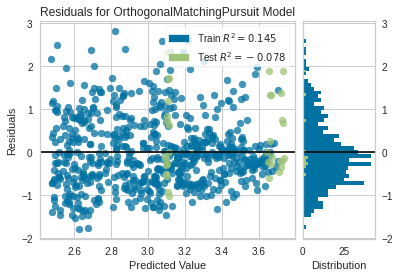

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [32]:
plot_model(best, plot = 'residuals')

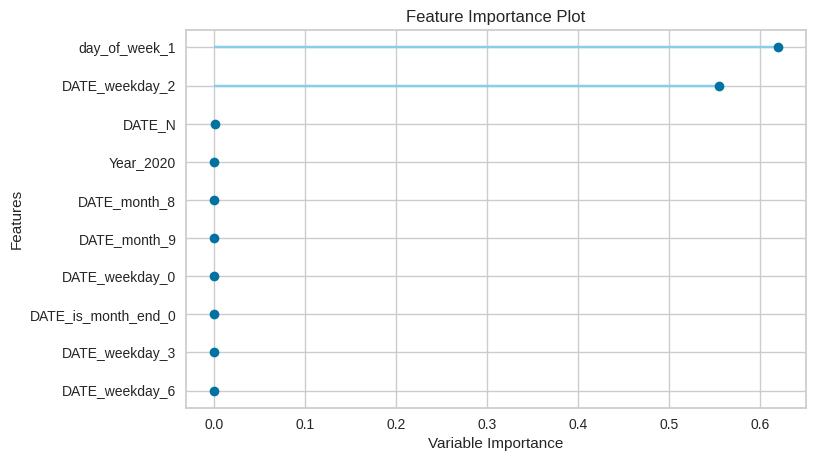

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [33]:
plot_model(best, plot = 'feature')

###Save the model

In [34]:
save_model(best, 'BGR_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), model_name=BGR_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['COUNTRY_NAME'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='logarithm_base2',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerica...
                ('scaling', 'passthrough'), ('

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['COUNTRY_NAME'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='logarithm_base2',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerica...
                 ('dummy', Dummify(target='logarithm_base2')),
                 ('fix_perfect', Remove_100(target='logarithm_base2')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'

###loading saved model

In [35]:
loaded_model = load_model('BGR_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=BGR_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


### creating future dataset

In [36]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([BGR_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [37]:
bgr_future = future_list[0].tail(10)
bgr_future = bgr_future.drop('logarithm_base2',axis = 1)
predictions_bgr = predict_model(best, data=bgr_future)
predictions_bgr['prediction'] = 10 ** predictions_bgr['Label'] 
predictions_bgr['COUNTRY_NAME'] ='BGR' 
prediction_df.append(predictions_bgr)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


### CEN ML

In [38]:
CEN_data = df_list[2].copy()
CEN_data = CEN_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)
 

### Setting the algorithms

In [39]:
s = setup(CEN_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

### comparing the models

In [40]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,7.266000e-01,7.084000e-01,8.398000e-01,8.700000e-02,0.1974,0.2315,1.3100
ada,AdaBoost Regressor,7.440000e-01,7.091000e-01,8.405000e-01,8.590000e-02,0.1986,0.2409,0.2500
gbr,Gradient Boosting Regressor,7.353000e-01,7.181000e-01,8.449000e-01,7.660000e-02,0.1986,0.2356,0.4367
et,Extra Trees Regressor,7.369000e-01,7.339000e-01,8.545000e-01,5.580000e-02,0.2007,0.2356,0.7400
dummy,Dummy Regressor,7.906000e-01,7.773000e-01,8.802000e-01,-3.000000e-03,0.2072,0.2546,0.0200
llar,Lasso Least Angle Regression,7.906000e-01,7.773000e-01,8.802000e-01,-3.000000e-03,0.2072,0.2546,0.0233
huber,Huber Regressor,7.914000e-01,7.779000e-01,8.805000e-01,-3.800000e-03,0.2074,0.2552,0.0333
lightgbm,Light Gradient Boosting Machine,7.507000e-01,7.877000e-01,8.857000e-01,-1.540000e-02,0.2068,0.2371,0.1200
knn,K Neighbors Regressor,7.957000e-01,8.358000e-01,9.131000e-01,-8.070000e-02,0.2138,0.2529,0.0333
omp,Orthogonal Matching Pursuit,7.866000e-01,8.827000e-01,9.230000e-01,-1.155000e-01,0.2194,0.2384,0.0200


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


### evaluating our best model

In [41]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### ploting the residuals 

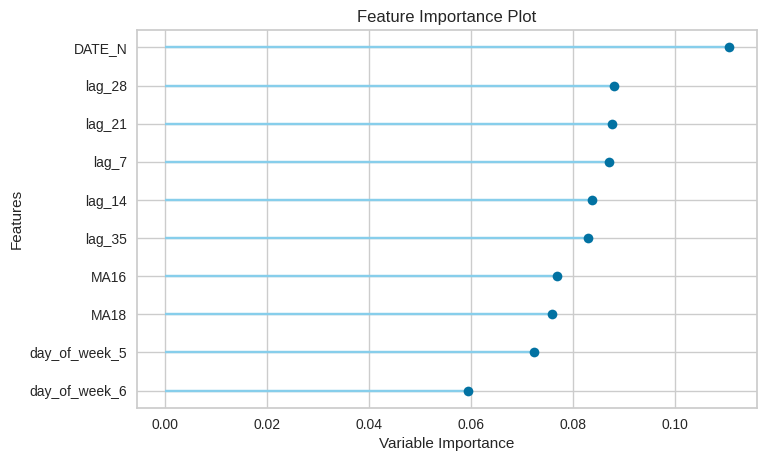

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [42]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

### saving our best model

In [43]:
save_model(best, 'CEN_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False), model_name=CEN_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['COUNTRY_NAME'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                           

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['COUNTRY_NAME'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='logarithm_base2',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerica...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max

### loading our model 

In [44]:
loaded_model = load_model('CEN_model')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=CEN_model, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


### creating future dataframe

In [45]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([CEN_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making prediction and appending 

In [46]:
cen_future = future_list[0].tail(10)
cen_future = cen_future.drop('logarithm_base2',axis = 1)
predictions_cen = predict_model(best, data=cen_future)
predictions_cen['prediction'] = 10 ** predictions_cen['Label'] 
predictions_cen['COUNTRY_NAME'] ='CEN' 
prediction_df.append(predictions_cen)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


### CES ML

In [47]:
CES_data = df_list[3].copy()
CES_data = CES_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)

In [48]:
s = setup(CES_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

In [49]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,5.530000e-01,4.360000e-01,6.583000e-01,1.265000e-01,0.1693,2.031000e-01,1.2533
gbr,Gradient Boosting Regressor,5.612000e-01,4.495000e-01,6.680000e-01,1.018000e-01,0.1724,2.083000e-01,0.4133
omp,Orthogonal Matching Pursuit,5.629000e-01,4.471000e-01,6.673000e-01,1.002000e-01,0.1719,2.061000e-01,0.0200
ada,AdaBoost Regressor,5.787000e-01,4.585000e-01,6.753000e-01,8.030000e-02,0.1756,2.198000e-01,0.2367
et,Extra Trees Regressor,5.713000e-01,4.772000e-01,6.883000e-01,4.520000e-02,0.1779,2.102000e-01,0.7233
lightgbm,Light Gradient Boosting Machine,5.790000e-01,4.966000e-01,7.023000e-01,4.900000e-03,0.1805,2.110000e-01,0.1267
huber,Huber Regressor,5.961000e-01,5.012000e-01,7.061000e-01,-5.900000e-03,0.1815,2.204000e-01,0.0267
dummy,Dummy Regressor,5.955000e-01,5.014000e-01,7.063000e-01,-6.400000e-03,0.1814,2.197000e-01,0.0167
llar,Lasso Least Angle Regression,5.955000e-01,5.014000e-01,7.063000e-01,-6.400000e-03,0.1814,2.197000e-01,0.0200
knn,K Neighbors Regressor,6.227000e-01,5.304000e-01,7.263000e-01,-6.390000e-02,0.1891,2.377000e-01,0.0333


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [50]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

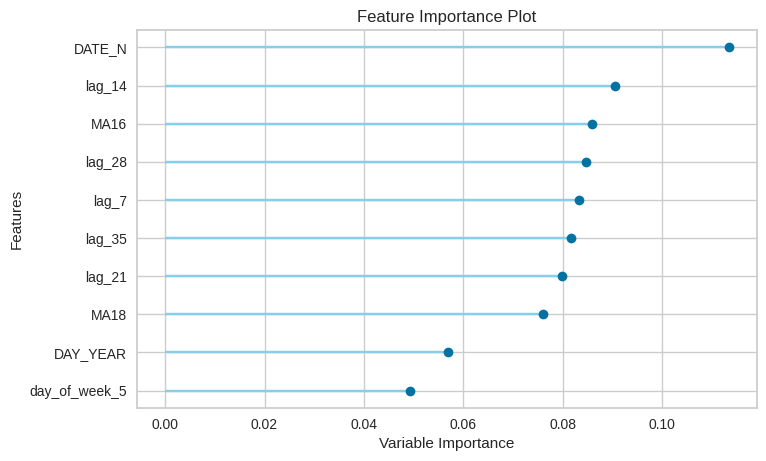

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [51]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

In [53]:
save_model(best, 'CES_model')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False), model_name=CES_model, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['COUNTRY_NAME'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                           

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['COUNTRY_NAME'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='logarithm_base2',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerica...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max

In [55]:
loaded_model = load_model('CES_model.pkl')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=CES_model.pkl, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


FileNotFoundError: ignored

In [56]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([CES_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

In [57]:
ces_future = future_list[0].tail(10)
ces_future = ces_future.drop('logarithm_base2',axis = 1)
predictions_ces = predict_model(best, data=ces_future)
predictions_ces['prediction'] = 10 ** predictions_ces['Label'] 
predictions_ces['COUNTRY_NAME'] ='CES' 
prediction_df.append(predictions_ces)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


### CHE ML

In [59]:
CHE_data = df_list[4].copy()
CHE_data = CHE_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)
 

### setting up the algorithms

In [60]:
s = setup(CHE_data, target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

In [61]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,1.035400e+00,1.467300e+00,1.211300e+00,5.130000e-02,0.2612,3.171000e-01,0.3100
gbr,Gradient Boosting Regressor,1.027000e+00,1.481500e+00,1.217100e+00,4.210000e-02,0.2623,3.150000e-01,0.5700
rf,Random Forest Regressor,1.035000e+00,1.497500e+00,1.223700e+00,3.170000e-02,0.2635,3.151000e-01,1.8133
et,Extra Trees Regressor,1.063900e+00,1.578900e+00,1.256400e+00,-2.090000e-02,0.2720,3.222000e-01,0.9833
dummy,Dummy Regressor,1.091200e+00,1.605400e+00,1.266800e+00,-3.800000e-02,0.2772,3.522000e-01,0.0400
llar,Lasso Least Angle Regression,1.091200e+00,1.605400e+00,1.266800e+00,-3.800000e-02,0.2772,3.522000e-01,0.0233
lightgbm,Light Gradient Boosting Machine,1.068300e+00,1.618900e+00,1.271900e+00,-4.680000e-02,0.2727,3.237000e-01,0.2567
huber,Huber Regressor,1.118000e+00,1.717800e+00,1.308600e+00,-1.108000e-01,0.2873,3.710000e-01,0.0300
knn,K Neighbors Regressor,1.160600e+00,1.792600e+00,1.338600e+00,-1.591000e-01,0.2855,3.514000e-01,0.0500
br,Bayesian Ridge,1.132500e+00,1.830400e+00,1.348700e+00,-1.836000e-01,0.2830,3.047000e-01,0.0233


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123)
INFO:logs:compare_models() succesfully completed......................................


In [62]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## plotting residues and features

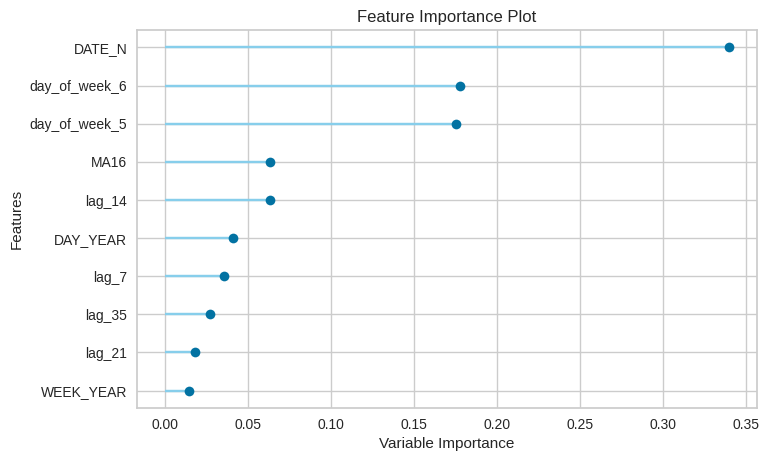

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [63]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'CHE_model')

In [ ]:
loaded_model = load_model('CHE_model')

### creating future dataset

In [64]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([CHE_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making predictions

In [65]:
che_future = future_list[0].tail(10)
che_future = che_future.drop('logarithm_base2',axis = 1)
predictions_che = predict_model(best, data=che_future)
predictions_che['prediction'] = 10 ** predictions_che['Label'] 
predictions_che['COUNTRY_NAME'] ='CHE' 
prediction_df.append(predictions_che)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


### DEU ML

In [66]:
DEU_data = df_list[5].copy()
DEU_data = DEU_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                                

### setting up the algorithm

In [67]:
s = setup(DEU_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logarithm_base2, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.95, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_feature

### comparing the models

In [68]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.5668,5.786000e-01,0.7570,-5.460000e-02,0.2262,0.3005,0.0300
llar,Lasso Least Angle Regression,0.6073,6.004000e-01,0.7704,-9.160000e-02,0.2273,0.3068,0.0167
dummy,Dummy Regressor,0.6073,6.004000e-01,0.7704,-9.160000e-02,0.2273,0.3068,0.0133
omp,Orthogonal Matching Pursuit,0.5845,6.191000e-01,0.7805,-1.201000e-01,0.2309,0.3022,0.0200
lasso,Lasso Regression,0.5802,6.388000e-01,0.7919,-1.545000e-01,0.2340,0.3050,0.0233
en,Elastic Net,0.5810,6.421000e-01,0.7938,-1.602000e-01,0.2345,0.3052,0.0200
knn,K Neighbors Regressor,0.5568,6.729000e-01,0.8148,-2.211000e-01,0.2409,0.3109,0.0300
lightgbm,Light Gradient Boosting Machine,0.6228,6.950000e-01,0.8289,-2.645000e-01,0.2417,0.3176,0.0867
br,Bayesian Ridge,0.6297,7.470000e-01,0.8464,-3.233000e-01,0.2463,0.3110,0.0200
et,Extra Trees Regressor,0.6580,7.576000e-01,0.8535,-3.479000e-01,0.2471,0.3163,0.4500


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


### evaluating the best model

In [69]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### ploting resudue and best features 

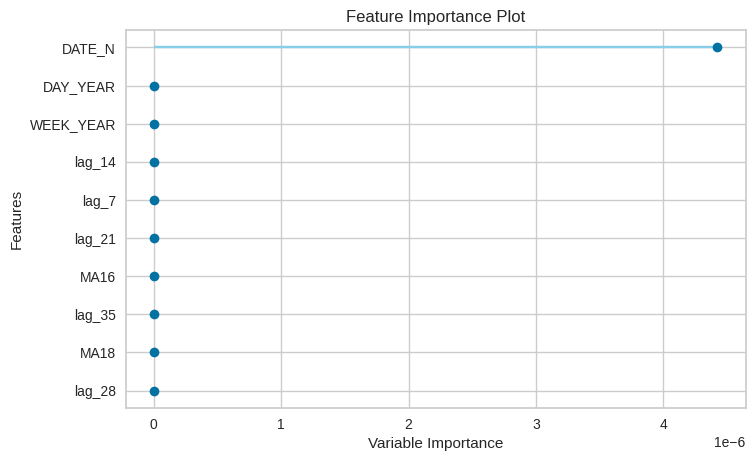

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [70]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

### saving the model

In [ ]:
save_model(best, 'DEU_model')

### loading the model

In [ ]:
loaded_model = load_model('DEU_model')

### preparing future datasets 

In [71]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates) 
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([DEU_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making predictions

In [72]:
deu_future = future_list[0].tail(10)
deu_future = deu_future.drop('logarithm_base2',axis = 1)
predictions_deu = predict_model(best, data=deu_future)
predictions_deu['prediction'] = 10 ** predictions_deu['Label'] 
predictions_deu['COUNTRY_NAME'] ='DEU' 
prediction_df.append(predictions_deu)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


### GRC ML

In [ ]:
GRC_data = df_list[6].copy()
GRC_data = GRC_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                         

### preparing the Algorithm

In [ ]:
s = setup(GRC_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

### comparing the models

In [ ]:
best = compare_models()

### evaluating the best model

In [ ]:
evaluate_model(best)

### plotting the residue and features

In [ ]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

### saving the model

In [ ]:
save_model(best, 'GRC_model')

### loading the model

In [ ]:
loaded_model = load_model('GRC_model')

### creating future dataset

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([GRC_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making predictions 

In [ ]:
grc_future = future_list[0].tail(10)
grc_future = grc_future.drop('logarithm_base2',axis = 1)
predictions_grc = predict_model(best, data=grc_future)
predictions_grc['prediction'] = 10 ** predictions_grc['Label'] 
predictions_grc['COUNTRY_NAME'] ='GRC' 
prediction_df.append(predictions_grc)

### ITA ML

In [ ]:
ITA_data = df_list[7].copy()
ITA_data = ITA_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)           

### setting up the algorithm

In [ ]:
s = setup(ITA_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

### comparing the models

In [ ]:
best = compare_models()

### evaluating the best model

In [ ]:
evaluate_model(best)

### ploting features and residues 

In [ ]:
plot_model(best, plot = 'residuals')
plot_model(best, plot = 'feature')

In [ ]:
save_model(best, 'ITA_model')

In [ ]:
loaded_model = load_model('ITA_model')

### creating future dataset

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([ITA_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making predictions

In [ ]:
ITA_future = future_list[0].tail(10)
ITA_future = ITA_future.drop('logarithm_base2',axis = 1)
predictions_ITA = predict_model(best, data=ITA_future)
predictions_ITA['prediction'] = 10 ** predictions_ITA['Label'] 
predictions_ITA['COUNTRY_NAME'] ='ITA' 
prediction_df.append(predictions_ITA)

### ROU ML

In [ ]:
ROU_data = df_list[8].copy()
ROU_data = ROU_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                    

### setting the algorithm

In [ ]:
s = setup(ROU_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

### comparing the models

In [ ]:
best = compare_models()

### evaluating the beast model

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')
save_model(best, 'ROU_model')

### loading the model

In [ ]:
loaded_model = load_model('ROU_model')

### preparing future dataset

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([ROU_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making prediction

In [ ]:
ROU_future = future_list[0].tail(10)
ROU_future = ROU_future.drop('logarithm_base2',axis = 1)
predictions_ROU = predict_model(best, data=ROU_future)
predictions_ROU['prediction'] = 10 ** predictions_ROU['Label'] 
predictions_ROU['COUNTRY_NAME'] ='ROU' 
prediction_df.append(predictions_ROU)

### TUR ML

In [ ]:
TUR_data = df_list[9].copy()
TUR_data = TUR_data.drop(['ORDTYP_map','SUM_QTY_PIECE_PICKS','NBR_ORDERS','SUM_QTY_TOTAL_PICKS'], axis=1)                   

### seting up the algorithm

In [ ]:
s = setup(TUR_data , target = 'logarithm_base2', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['COUNTRY_NAME'],
          #numeric_features = ['day_of_year', 'year'],categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)

### comparing the models

In [ ]:
best = compare_models()

### evaluating the best model

In [ ]:
evaluate_model(best)

## ploting residue and feature 

In [ ]:
plot_model(best, plot = 'residuals')

In [ ]:
plot_model(best, plot = 'feature')

### saving the model

In [ ]:
save_model(best, 'TUR_model')

### loading the model

In [ ]:
loaded_model = load_model('TUR_model')

### creating future datasets

In [ ]:
future_dates = pd.date_range(start=date.today(), periods=6, freq='d')
future_data = pd.DataFrame(future_dates)
# add columns
future_data.columns = ['DATE']
future_df = pd.concat([TUR_data,future_data],ignore_index=True).fillna(0)

future_list =[]
future_list.append(future_df)
for df in future_list:
    add_values(df)
    lag = [7,14,21,28,35]
    for val in df.logarithm_base2:
        for l in lag:
            df.loc[:,'lag'+"_"+str(l)] = df.logarithm_base2.shift(l)

### making predictions

In [ ]:
TUR_future = future_list[0].tail(10)
TUR_future = TUR_future.drop('logarithm_base2',axis = 1)
predictions_TUR = predict_model(best, data=TUR_future)
predictions_TUR['prediction'] = 10 ** predictions_TUR['Label'] 
predictions_TUR['COUNTRY_NAME'] ='TUR' 
prediction_df.append(predictions_TUR)

### concatenating all predictions to one dataset 

In [ ]:
concatenated_predictions = pd.concat(prediction_df)

### Register our Data output

In [ ]:
try:
    Dataset.Tabular.register_pandas_dataframe(dataframe = concatenated_predictions,
                                               target = az_store,
                                               name = 'predictions_contries',
                                                description='predictions_from all countries')
except Exception as ex:
    print('Error register_pandas_dataframe: ', ex)

Message: rslex failed, falling back to clex.
Payload: {"pid": 4666, "source": "azureml.dataprep", "version": "4.8.3", "trace": "azureml|data|dataset_factory.py, line 655 in function register_pandas_dataframe.\nazureml|data|_loggerfactory.py, line 132 in function wrapper.\n<ipython-input-170-8c7b7ab23f2e>, line 2 in function <module>.", "subscription": "", "run_id": "", "resource_group": "", "workspace_name": "", "experiment_id": "", "location": "", "rslex_version": "2.15.1"}


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/72d6b203-81bd-43d8-8262-6bb664478261/
Successfully uploaded file to datastore.
Creating and registering a new dataset.


Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


Successfully created and registered a new dataset.


### complete the experiment

In [ ]:
experiment_run.complete()